## 멀티모달 RAG

많은 문서들은 텍스트와 이미지를 포함한 다양한 콘텐츠 유형의 혼합을 담고 있습니다.

그러나 대부분의 RAG 애플리케이션에서 이미지에 담긴 정보는 손실됩니다.

GPT-4V, GPT4o 와 같은 다중 모달 LLM의 등장으로, RAG에서 이미지를 활용하는 방법을 고려하는 것이 가치가 있습니다:

`옵션 1:`

- 다중 모달 임베딩(예: [CLIP](https://openai.com/research/clip))을 사용하여 이미지와 텍스트를 임베딩합니다.
- 유사성 검색을 사용하여 둘 다 검색합니다.
- 다중 모달 LLM에 원본 이미지와 텍스트 조각을 전달하여 답변을 합성합니다.

`옵션 2:`

- 다중 모달 LLM(예: GPT-4V, GPT4o, [LLaVA](https://llava.hliu.cc/), [FUYU-8b](https://www.adept.ai/blog/fuyu-8b))을 사용하여 이미지에서 텍스트 요약을 생성합니다.
- 텍스트를 임베딩하고 검색합니다.
- LLM에 텍스트 조각을 전달하여 답변을 합성합니다.

`옵션 3`

- 다중 모달 LLM(예: GPT-4V, GPT4o, [LLaVA](https://llava.hliu.cc/), [FUYU-8b](https://www.adept.ai/blog/fuyu-8b))을 사용하여 이미지에서 텍스트 요약을 생성합니다.
- 원본 이미지에 대한 참조와 함께 이미지 요약을 임베딩하고 검색합니다.
- 다중 모달 LLM에 원본 이미지와 텍스트 조각을 전달하여 답변을 합성합니다.

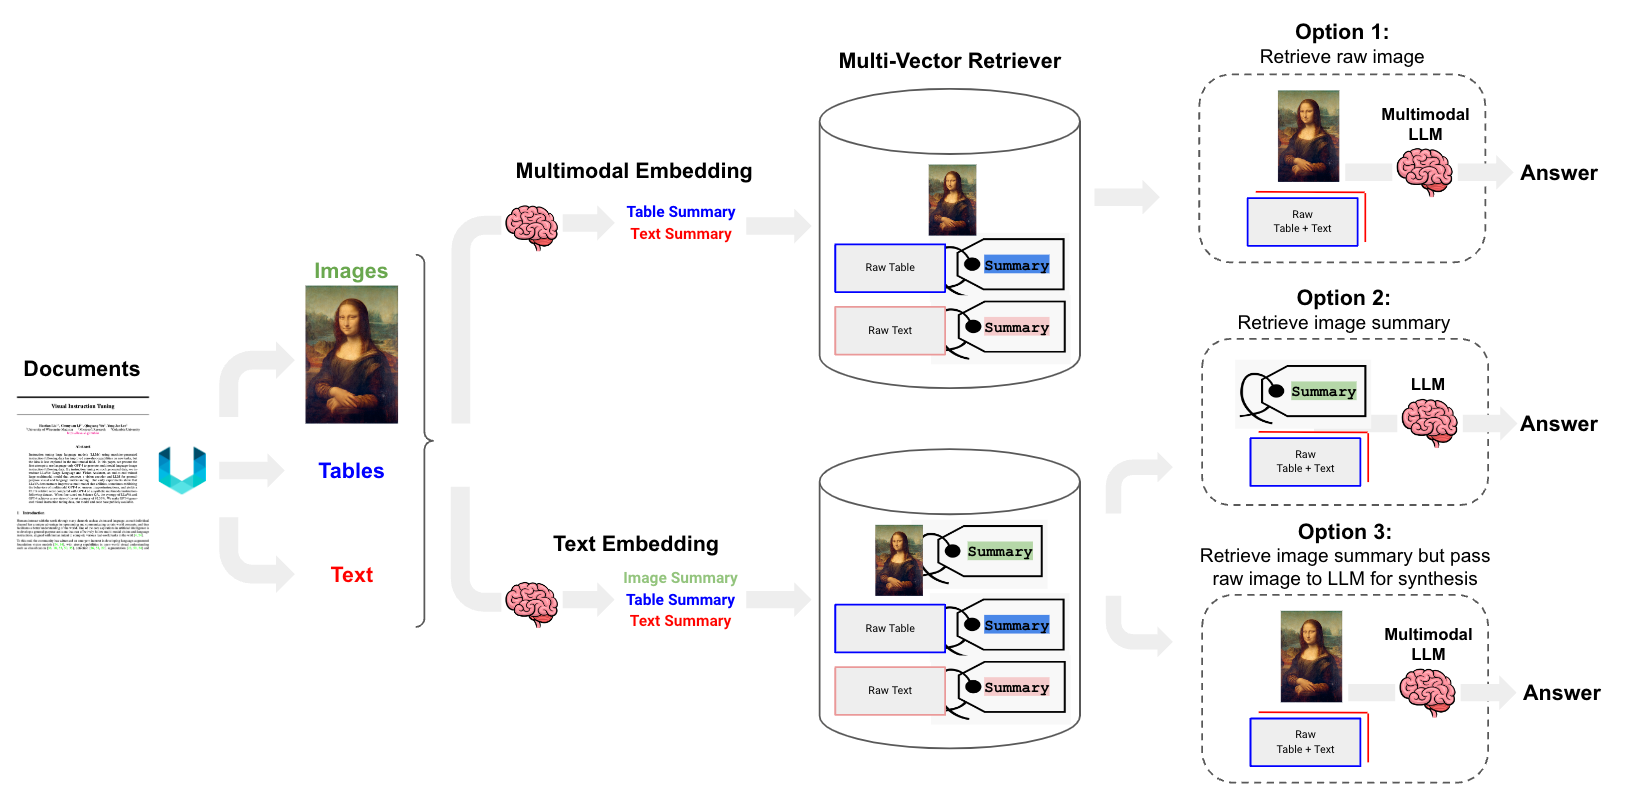


## 데이터

- [다운로드 링크](https://drive.google.com/file/d/1QlhGFIFwEkNEjQGOvV_hQe4bnOLDJwCR/view)
- 출처: [Jamin Ball Blog](https://cloudedjudgement.substack.com/p/clouded-judgement-111023).


## 패키지

`unstructured`를 사용하기 위해서는 시스템에 `poppler`([설치 지침](https://pdf2image.readthedocs.io/en/latest/installation.html))와 `tesseract`([설치 지침](https://tesseract-ocr.github.io/tessdoc/Installation.html))가 필요합니다.

[참고] `옵션 2`는 다중 모달 LLM을 답변 합성에 사용할 수 없는 경우(예: 비용 등)에 적합합니다.


In [ ]:
# ! pip install -U langchain openai chromadb langchain-experimental # 최신 버전이 필요합니다 (멀티 모달을 위해)

In [ ]:
# ! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

## 데이터 로딩

### PDF 텍스트와 이미지 분할

[Unstructured](https://unstructured-io.github.io/unstructured/introduction.html#key-concepts)에서 제공하는 `partition_pdf`를 사용하여 텍스트와 이미지를 추출할 수 있습니다.

이미지를 추출하기 위해 다음을 사용합니다

`extract_images_in_pdf=True`

텍스트만 처리하려는 경우.

`extract_images_in_pdf=False`


In [2]:
# 파일 경로
fpath = "multi-modal/"
fname = "sample.pdf"

In [3]:
import os
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf

# PDF에서 요소 추출


def extract_pdf_elements(path, fname):
    """
    PDF 파일에서 이미지, 테이블, 그리고 텍스트 조각을 추출합니다.
    path: 이미지(.jpg)를 저장할 파일 경로
    fname: 파일 이름
    """
    return partition_pdf(
        filename=os.path.join(path, fname),
        extract_images_in_pdf=True,  # PDF 내 이미지 추출 활성화
        infer_table_structure=True,  # 테이블 구조 추론 활성화
        chunking_strategy="by_title",  # 제목별로 텍스트 조각화
        max_characters=4000,  # 최대 문자 수
        new_after_n_chars=3800,  # 이 문자 수 이후에 새로운 조각 생성
        combine_text_under_n_chars=2000,  # 이 문자 수 이하의 텍스트는 결합
        image_output_dir_path=path,  # 이미지 출력 디렉토리 경로
    )


# 요소를 유형별로 분류


def categorize_elements(raw_pdf_elements):
    """
    PDF에서 추출된 요소를 테이블과 텍스트로 분류합니다.
    raw_pdf_elements: unstructured.documents.elements의 리스트
    """
    tables = []  # 테이블 저장 리스트
    texts = []  # 텍스트 저장 리스트
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))  # 테이블 요소 추가
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))  # 텍스트 요소 추가
    return texts, tables


# 요소 추출
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# 텍스트, 테이블 추출
texts, tables = categorize_elements(raw_pdf_elements)

# 선택사항: 텍스트에 대해 특정 토큰 크기 적용
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0  # 텍스트를 4000 토큰 크기로 분할, 중복 없음
)
joined_texts = " ".join(texts)  # 텍스트 결합
texts_4k_token = text_splitter.split_text(joined_texts)  # 분할 실행

OMP: Warning #96: Cannot form a team with 16 threads, using 1 instead.
OMP: Hint Consider unsetting KMP_DEVICE_THREAD_LIMIT (KMP_ALL_THREADS), KMP_TEAMS_THREAD_LIMIT, and OMP_THREAD_LIMIT (if any are set).
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly id

In [6]:
len(texts_4k_token)

4

## 멀티-벡터 검색기

[multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary)를 사용하여 이미지(그리고/또는 텍스트, 테이블) 요약을 색인화하지만, 원본 이미지(원본 텍스트나 테이블과 함께)를 검색합니다.

### 텍스트 및 테이블 요약

테이블과 선택적으로 텍스트 요약을 생성하기 위해 `GPT-4-turbo`를 사용할 것입니다.

큰 청크 크기를 사용하는 경우(예를 들어, 위에서 설정한 것처럼 4k 토큰 청크를 사용) 텍스트 요약이 권장됩니다.

요약은 원본 테이블 및/또는 원본 텍스트 청크를 검색하는 데 사용됩니다.


In [4]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 텍스트 요소의 요약 생성


def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    텍스트 요소 요약
    texts: 문자열 리스트
    tables: 문자열 리스트
    summarize_texts: 텍스트 요약 여부를 결정. True/False
    """

    # 프롬프트 설정
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # 텍스트 요약 체인
    model = ChatOpenAI(temperature=0, model="gpt-4")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # 요약을 위한 빈 리스트 초기화
    text_summaries = []
    table_summaries = []

    # 제공된 텍스트에 대해 요약이 요청되었을 경우 적용
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # 제공된 테이블에 적용
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# 텍스트, 테이블 요약 가져오기
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

### 이미지 요약

`GPT-4o`를 사용하여 이미지 요약을 생성할 것입니다.

- base64로 인코딩된 이미지를 전달합니다.


In [8]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    # 이미지 파일을 base64 문자열로 인코딩합니다.
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    # 이미지 요약을 생성합니다.
    chat = ChatOpenAI(model="gpt-4o", max_tokens=2048)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    이미지에 대한 요약과 base64 인코딩된 문자열을 생성합니다.
    path: Unstructured에 의해 추출된 .jpg 파일 목록의 경로
    """

    # base64로 인코딩된 이미지를 저장할 리스트
    img_base64_list = []

    # 이미지 요약을 저장할 리스트
    image_summaries = []

    # 요약을 위한 프롬프트
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # 이미지에 적용
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# 이미지 요약 실행
img_base64_list, image_summaries = generate_img_summaries(fpath)

In [9]:
len(image_summaries)

24

### 벡터 저장소에 추가하기

원본 문서와 문서 요약을 [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary)에 추가하는 방법:

- 원본 텍스트, 테이블, 이미지를 `docstore`에 저장합니다.
- 효율적인 의미론적 검색을 위해 텍스트, 테이블 요약, 이미지 요약을 `vectorstore`에 저장합니다.


다양한 유형의 데이터(텍스트, 테이블, 이미지)를 색인화하고 검색할 수 있는 멀티 벡터 검색기를 생성하는 과정을 설명합니다.

- `InMemoryStore`를 사용하여 저장 계층을 초기화합니다.
- `MultiVectorRetriever`를 생성하여, 요약된 데이터를 색인화하지만 원본 텍스트나 이미지를 반환하도록 설정합니다.
- 각 데이터 유형(텍스트, 테이블, 이미지)에 대해 요약과 원본 데이터를 `vectorstore`와 `docstore`에 추가하는 과정을 포함합니다.
  - 각 문서에 대해 고유한 `doc_id`를 생성합니다.
  - 요약된 데이터를 `vectorstore`에 추가하고, 원본 데이터와 `doc_id`를 `docstore`에 저장합니다.
- 데이터 유형별로 요약이 비어 있지 않은 경우에만 해당 데이터를 추가하는 조건을 확인합니다.
- `Chroma` 벡터 저장소를 사용하여 요약을 색인화하고, `OpenAIEmbeddings` 함수를 사용하여 임베딩을 생성합니다.
- 생성된 멀티 벡터 검색기는 다양한 유형의 데이터에 대한 요약을 색인화하고, 검색 시 원본 데이터를 반환할 수 있습니다.


In [10]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    요약을 색인화하지만 원본 이미지나 텍스트를 반환하는 검색기를 생성합니다.
    """

    # 저장 계층 초기화
    store = InMemoryStore()
    id_key = "doc_id"

    # 멀티 벡터 검색기 생성
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # 문서를 벡터 저장소와 문서 저장소에 추가하는 헬퍼 함수
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [
            str(uuid.uuid4()) for _ in doc_contents
        ]  # 문서 내용마다 고유 ID 생성
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(
            summary_docs
        )  # 요약 문서를 벡터 저장소에 추가
        retriever.docstore.mset(
            list(zip(doc_ids, doc_contents))
        )  # 문서 내용을 문서 저장소에 추가

    # 텍스트, 테이블, 이미지 추가
    if text_summaries:
        add_documents(retriever, text_summaries, texts)

    if table_summaries:
        add_documents(retriever, table_summaries, tables)

    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

In [33]:
# 요약을 색인화하기 위해 사용할 벡터 저장소
vectorstore = Chroma(
    collection_name="sample-rag-multi-modal", embedding_function=OpenAIEmbeddings()
)

# 검색기 생성
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

## RAG

### 검색기 구축

검색된 문서를 GPT-4o 프롬프트 템플릿의 올바른 부분에 할당해야 합니다.


다음은 Base64 인코딩된 이미지와 텍스트를 처리하고, 이를 활용하여 다중 모달 질의응답(질문-응답) 체인을 구성하는 방법을 설명합니다.

- Base64 인코딩된 문자열이 이미지인지 확인합니다. 지원하는 이미지 포맷은 JPG, PNG, GIF, WEBP입니다.
- Base64 인코딩된 이미지를 주어진 크기로 리사이즈합니다.
- 문서 집합에서 Base64 인코딩된 이미지와 텍스트를 분리합니다.
- 분리된 이미지와 텍스트를 사용하여 다중 모달 질의응답 체인의 입력으로 사용될 메시지를 구성합니다. 이 과정에서 이미지 URL과 텍스트 정보를 포함하는 메시지를 생성합니다.
- 다중 모달 질의응답 체인을 구성합니다. 이 체인은 입력된 이미지와 텍스트 정보를 바탕으로 질문에 대한 응답을 생성하는 과정을 포함합니다. 사용된 모델은 `ChatOpenAI`이며, `gpt-4o` 모델을 사용합니다.

이 과정은 이미지와 텍스트 데이터를 모두 활용하여 질문에 대한 응답을 생성하는 다중 모달 질의응답 시스템을 구현하는 방법을 제시합니다. 여기서는 이미지 데이터를 처리하기 위한 Base64 인코딩 및 디코딩, 이미지 리사이징, 그리고 이를 텍스트 정보와 함께 처리하여 질문에 대한 응답을 생성하는 과정이 포함됩니다.


In [26]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """base64 인코딩된 문자열을 이미지로 표시"""
    # base64 문자열을 소스로 사용하는 HTML img 태그 생성
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # HTML을 렌더링하여 이미지 표시
    display(HTML(image_html))


def looks_like_base64(sb):
    """문자열이 base64로 보이는지 확인"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    base64 데이터가 이미지인지 시작 부분을 보고 확인
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # 처음 8바이트를 디코드하여 가져옴
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Base64 문자열로 인코딩된 이미지의 크기 조정
    """
    # Base64 문자열 디코드
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # 이미지 크기 조정
    resized_img = img.resize(size, Image.LANCZOS)

    # 조정된 이미지를 바이트 버퍼에 저장
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # 조정된 이미지를 Base64로 인코딩
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    base64로 인코딩된 이미지와 텍스트 분리
    """
    b64_images = []
    texts = []
    for doc in docs:
        # 문서가 Document 타입인 경우 page_content 추출
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    컨텍스트를 단일 문자열로 결합
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # 이미지가 있으면 메시지에 추가
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # 분석을 위한 텍스트 추가
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. Answer in Korean. Do NOT translate company names.\n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    멀티모달 RAG 체인
    """

    # 멀티모달 LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=2048)

    # RAG 파이프라인
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# RAG 체인 생성
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

### 검사

우리가 질문에 관련된 이미지를 검색할 때, 관련성 있는 이미지들을 되돌려 받습니다.


In [34]:
# 검색 질의 실행
query = "EV/NTM 및 NTM 매출 성장률을 기준으로 흥미로운 투자처인 기업 이름을 알려주세요. EV/NTM 멀티플과 과거를 고려하시나요?"

# 질의에 대한 문서 6개를 검색합니다.
docs = retriever_multi_vector_img.invoke(query, limit=6)

# 문서의 개수 확인
len(docs)  # 검색된 문서의 개수를 반환합니다.

4

In [62]:
# 검색 결과 확인
query = "Mongo DB, Cloudflare, Datadog 의 EV/NTM 및 NTM rev 성장률은 얼마인가요?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# 문서의 개수 확인
len(docs)

4


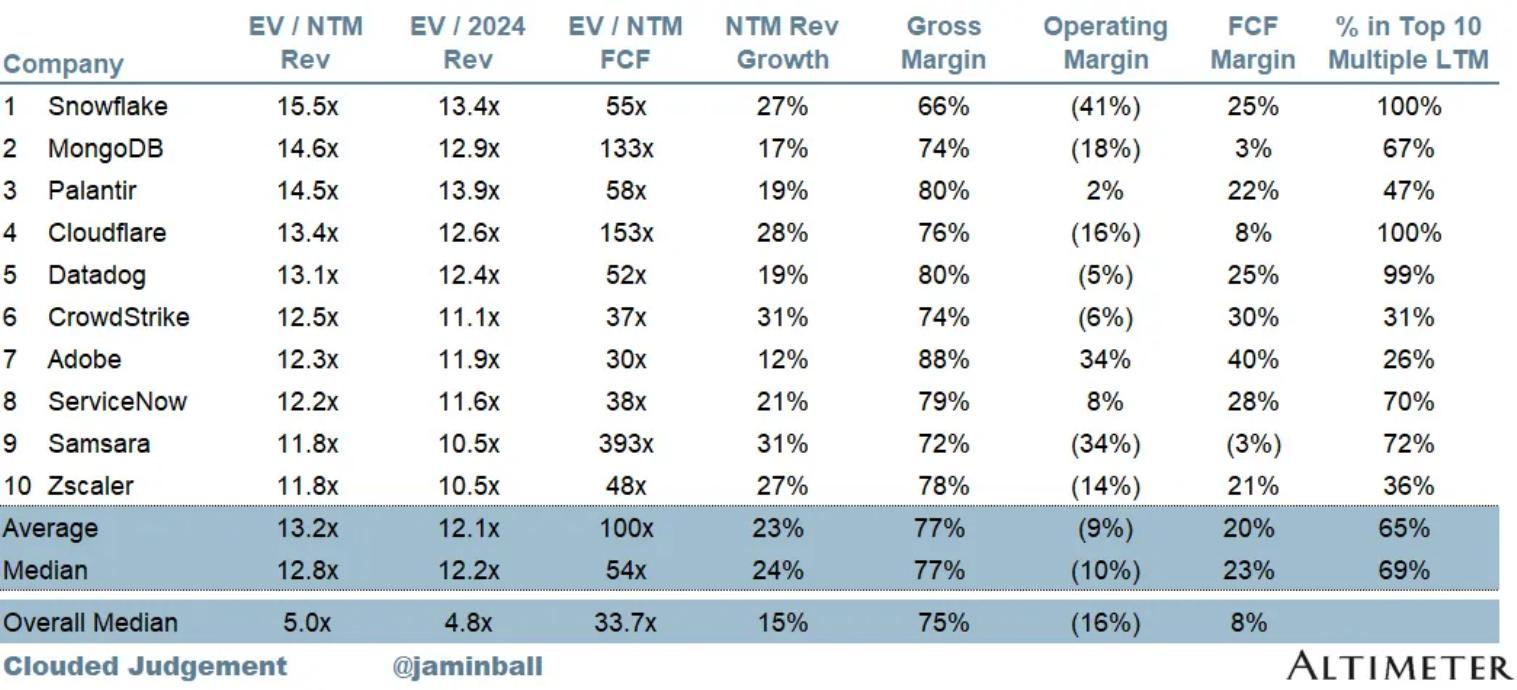

In [63]:
# 관련 이미지를 반환합니다.
plt_img_base64(docs[0])

### 검증

이것이 왜 작동하는지, 우리가 저장했던 이미지를 다시 살펴보겠습니다.



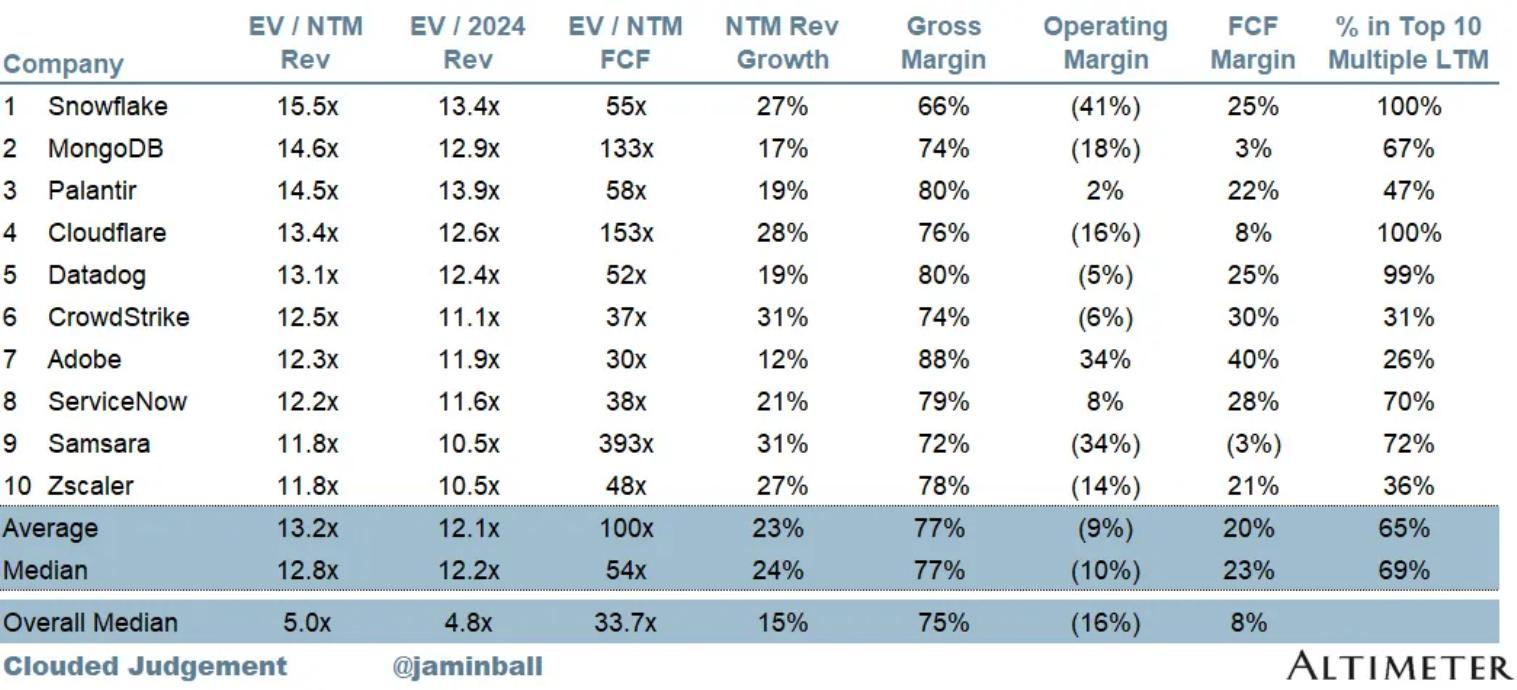

In [64]:
# img_base64_list 리스트의 20번 index 이미지를 base64 형식으로 표시합니다.
plt_img_base64(img_base64_list[20])

여기 해당 요약이 있으며, 우리는 이를 유사성 검색에 사용하기 위해 내장했습니다.

이 이미지가 우리의 `query`를 기반으로 그 요약과의 유사성 때문에 검색된 것은 상당히 합리적입니다.


In [65]:
image_summaries[20]  # image_summaries 리스트의 네 번째 요소에 접근합니다.

'Table comparing key financial metrics of ten companies, including Snowflake, MongoDB, Palantir, Cloudflare, Datadog, CrowdStrike, Adobe, ServiceNow, Samsara, and Zscaler. Metrics include EV/NTM Revenue, EV/2024 Revenue, EV/NTM FCF, NTM Revenue Growth, Gross Margin, Operating Margin, FCF Margin, and % in Top 10 Multiple LTM. Averages and medians are provided at the bottom. The image is branded by Altimeter and tagged with "Clouded Judgement" and @jaminball.'

### RAG

이제 RAG를 실행하고 우리의 질문에 대한 답변을 종합하는 능력을 테스트해 보겠습니다.


In [66]:
# RAG 체인 실행
print(chain_multimodal_rag.invoke(query))

MongoDB, Cloudflare, Datadog의 EV/NTM 및 NTM rev 성장률은 다음과 같습니다:

1. **MongoDB**
   - EV/NTM: 14.6x
   - NTM rev 성장률: 17%

2. **Cloudflare**
   - EV/NTM: 13.4x
   - NTM rev 성장률: 28%

3. **Datadog**
   - EV/NTM: 13.1x
   - NTM rev 성장률: 19%

이 정보를 바탕으로 투자 결정을 내리실 때 참고하시기 바랍니다.


### 고려사항

**검색**

- 검색은 이미지 요약과 텍스트 Chunk 와의 유사성을 기반으로 수행됩니다.
- 이는 이미지 요약 검색 결과보다 다른 Text Chunk 가 경쟁 우위에 있을 경우 실패할 수 있기 때문에 신중한 고려가 필요합니다.

**이미지 크기**

- 답변 합성의 품질은 이미지 크기에 민감한 것으로 보입니다. [가이드에 명시 된 것 처럼..](https://platform.openai.com/docs/guides/vision).
